In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# Carga del dataset

Vamos a utilizar un dataset muy gracioso de dibujitos a mano que hizo Google. Está guardado como un archivo ```.npy``` (NumPy bitmap), así que tendremos que cargarlo primero con NumPy.

In [2]:
data = np.load("Datasets/full_numpy_bitmap_camel.npy")

In [3]:
data.shape

(121399, 784)

Está guardado con las imágenes ya estiradas, pero como queremos utilizar capas convolucionales, lo ponemos en forma de imagen:

In [4]:
data_img = data.reshape(-1, 28, 28)
data_img.shape

(121399, 28, 28)

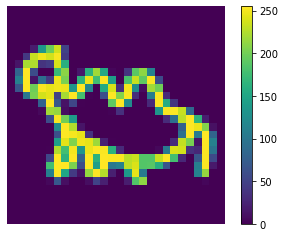

In [5]:
plt.figure()
plt.imshow(data_img[0])
plt.colorbar()
plt.axis('off')
plt.show()

Como vemos, los valores de los píxeles están en el intervalo [[0, 255]], pero para utilizarlos con nuestra GAN lo normalizaremos a [[-1, 1]]:

In [6]:
data_img_s = (data_img - data_img.max()/2) / (data_img.max()/2)

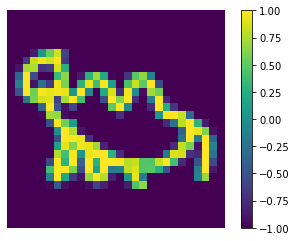

In [7]:
plt.figure()
plt.imshow(data_img_s[0])
plt.colorbar()
plt.axis('off')
plt.show()

Parece que para convertir esto en un ```Dataset``` personalizado de PyTorch también tenemos que utilizar la herencia de la clase original ```Dataset```, así que vamos a ver qué tal:

In [8]:
class Ganimals(torch.utils.data.Dataset):
    def __init__(self, images, transform = None):
        super(Ganimals, self).__init__()
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index): #Se supone que el parámetro index lo utilizará el DataLoader  
        image = self.images[index]
        if transform:
            image = self.transform(image)

        return image

In [9]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x - x.max()/2) / (x.max()/2))
])

In [10]:
#No he encontrado ninguna función que le haga reshape, así que hay que pasarle las fotos ya con el tamaño que toca
dataset = Ganimals(data_img, transform)

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1)

torch.Size([1, 1, 28, 28])


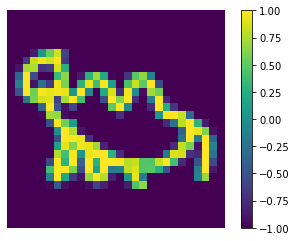

In [12]:
for X in dataloader:
    print(X.shape)
    plt.figure()
    plt.imshow(X.reshape(28,28))
    plt.colorbar()
    plt.axis('off')
    plt.show()
    break

# El Discriminador

Su objetivo es predeir si una imagen es real o no. Esto es un problema de clasificación binaria, por lo que podemos usar una red convolucional normal y corriente

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.linear1 = nn.Linear(in_features=5*5*64, out_features=512)
        self.linearfinal = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        pred = F.relu(self.conv1(x))
        pred = nn.MaxPool2d(kernel_size=2)(pred)
        pred = F.relu(self.conv2(pred))
        pred = nn.MaxPool2d(kernel_size=2)(pred)
        pred = nn.Flatten()(pred)
        pred = F.relu(self.linear1(pred))
        # pred = F.sigmoid(self.linearfinal(pred))
        pred = self.linearfinal(pred)
        return pred

# El Generador

Normalmente, la entrada del generador es un vector extraído de una distribución normal multivariante. La salida es una imagen con las mismas dimensiones que las imágenes originales. Esta descripción recuerda a los AutoEncoders Variacionales, y eso es porque el generador de una GAN actúa bajo el mismo principio que el decoder de un VAE: transforma un vector del espacio latente en una imagen (aunque podría ser cualquier otra cosa).

La idea de mapear el espacio latente al espacio original es algo muy común en el modelado generativo, ya que podemos manipular el espacio latente para afectar a las características de los elementos generados.

Para seguir el libro vamos a samplear vectores de 100 elementos, y la idea es ir haciéndolos cada vez más parecidos a una imagen por medio del UpSampling e intercalarlo con convolucionales como hacíamos con el VAE. En principio también podríamos usar convolucionales traspuestas, pero así probamos la otra forma de hacerlo. Además, el señor comenta que al utilizar convolucionales de stride 2, la imagen producida es propensa a tener pequeños artefactos como un tablero de ajedrez.

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(in_features=100, out_features=7*7*64)
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        pred = F.relu(self.linear1(x))
        pred = pred.view(-1, 64, 7, 7) #CxHxW
        pred = nn.Upsample(scale_factor=2)(pred)
        pred = F.relu(self.conv1(pred))
        pred = nn.Upsample(scale_factor=2)(pred)
        pred = F.tanh(self.conv2(pred)) #Ponemos tanh porque hemos transformado el input a [-1,1], si fuera [0,1] podríamos poner relu o sigmoid
        return pred

# Entrenamiento

Como hemos visto, la arquitectura de las GANs no es especialmente complicada y se parece mucho a un VAE, pero la gracia está en el entrenamiento. 

Podemos entrenar el discriminador creando un set de entrenamiento dónde algunas de las imágenes son imágenes reales elegidas aleatoriamente y algunas son salidas del generador. La etiqueta será 1 para las imágenes reales y 0 para las generadas. Si tratamosesto como un problema supervisado, podemos entrenar el discriminador para que nos diga la diferencia entre las imágenes originales y las generadas.

Entrenar el generador es más difícil, ya que no hay ningún set de entrenamiento que nos diga a qué imágen debería estar mapeado un punto del espacio latente. En su lugar, solo queremos la imagen generada para engañar al discriminador, es decir, queremos que cuándo le pasemos una imagen generada al discriminador, el resultado sea lo más cercano a 1 posible (que se piense que es de verdad). Esto implica que para entrenar el generador, primero tenemos que conectarlo al discriminador. Podemos entrenar este modelo combinado creando batches que consistan de vectores del espacio latente de etiqueta 1. Como función coste utilizaremos la binary cross-entropy entre la salida del discriminador y el vector de etiquetas (que son todo 1s).

Es importante no actualizar los pesos del discriminador mientras entrenamos el modelo combinado para que solamente se actualicen los pesos del generador. Si no lo hacemos, los pesos del discriminador se ajustarán para predecir las imágenes generadas como reales, lo no es lo que queremos. Queremos que las prediga como reales porque el gegenerador sea bueno, no porque el discriminador sea malo.

In [15]:
dataset = Ganimals(data_img, transform)
train = torch.utils.data.DataLoader(dataset, batch_size = 16, shuffle = True)

In [16]:
device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Elige GPU si está disponible y CPU si no
device

device(type='cuda', index=0)

In [17]:
# device = "cpu"

In [18]:
#Definimos el Discriminador y el Generador
disc = Discriminator()
disc.to(device)
gen = Generator()
gen.to(device)

Generator(
  (linear1): Linear(in_features=100, out_features=3136, bias=True)
  (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [19]:
optimizer_disc = torch.optim.RMSprop(disc.parameters(), lr=0.0008)
optimizer_gen = torch.optim.RMSprop(gen.parameters(), lr=0.0004)
loss_fn = nn.BCEWithLogitsLoss()

In [20]:
def accuracy_score(output, y_true):
    y_pred = torch.where(output > 0.5, 1, 0)
    y_pred.to(device)
    return sum(y_pred == y_true)/len(y_true)

In [21]:
CUDA_LAUNCH_BLOCKING=1 

In [22]:
epochs = 15
losses_true_epoch = []
losses_fake_epoch = []
losses_gen_epoch = []
accuracies_true_epoch = []
accuracies_fake_epoch = []
accuracies_gen_epoch = []

for epoch in range(epochs):
    for X in train:
        #Listas de trackeo
        losses_true_batch = []
        losses_fake_batch = []
        losses_gen_batch = []
        accuracies_true_batch = []
        accuracies_fake_batch = []
        accuracies_gen_batch = []

        #Pasamos el batch a GPU
        X = X.to(device)

        #Primero se entrena el discriminador con los verdaderos
        X_true = X
        Y_true = torch.ones((len(X_true),1), device = device)
    
        pred_true = disc(X_true)
        loss_true = loss_fn(pred_true, Y_true)
        # print("True -> ",pred_true.shape, Y_true.shape)
        loss_true.backward()
        # optimizer_disc.step() En el tutorial de PyTorch esto lo quitan
        # optimizer_disc.zero_grad() 
        with torch.no_grad():
            latent_vectors = torch.randn((64,100), device = device)
            X_fake = gen(latent_vectors)
            Y_fake = torch.zeros((len(X_fake),1), device = device)

        pred_fake = disc(X_fake)     
        loss_fake = loss_fn(pred_fake, Y_fake)
        # print("Fake -> ",pred_fake.shape, Y_fake.shape)
        loss_fake.backward()
        optimizer_disc.step()
        optimizer_disc.zero_grad() 

        losses_true_batch.append(loss_true)
        accuracies_true_batch.append(accuracy_score(pred_true, Y_true))

        losses_fake_batch.append(loss_fake)
        accuracies_fake_batch.append(accuracy_score(pred_fake, Y_fake))

        #Luego se entrena el generador
        latent_vectors = torch.randn((64,100), device = device)
        X_gen = gen(latent_vectors)
        Y_gen = torch.ones((len(X_gen),1), device = device)

        # with torch.no_grad():
        pred_gen = disc(X_gen)
        # print("Gen -> ",pred_gen.shape, Y_gen.shape)
        loss_gen = loss_fn(pred_gen, Y_gen)
        loss_gen.backward()
        optimizer_gen.step()
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()

        losses_gen_batch.append(loss_gen)
        accuracies_gen_batch.append(accuracy_score(pred_gen, Y_gen))
        # break
      
    losses_true_epoch.append(torch.mean(torch.Tensor(losses_true_batch)))
    losses_fake_epoch.append(torch.mean(torch.Tensor(losses_fake_batch)))
    losses_gen_epoch.append(torch.mean(torch.Tensor(losses_gen_batch)))

    accuracies_true_epoch.append(torch.mean(torch.Tensor(accuracies_true_batch)))
    accuracies_fake_epoch.append(torch.mean(torch.Tensor(accuracies_fake_batch)))
    accuracies_gen_epoch.append(torch.mean(torch.Tensor(accuracies_gen_batch)))
    print(f"Época {epoch} -> Loss: (True) {losses_true_epoch[-1]} (Fake) {losses_fake_epoch[-1]} (Gen) {losses_gen_epoch[-1]}| Accuracy: (True) {accuracies_true_epoch[-1]} (Fake) {accuracies_fake_epoch[-1]} (Gen) {accuracies_gen_epoch[-1]}")

Época 0 -> Loss: (True) 0.0 (Fake) 0.0 (Gen) 20.992794036865234| Accuracy: (True) 1.0 (Fake) 1.0 (Gen) 0.0
Época 1 -> Loss: (True) 0.0 (Fake) 0.0 (Gen) 24.730188369750977| Accuracy: (True) 1.0 (Fake) 1.0 (Gen) 0.0
Época 2 -> Loss: (True) 1.0818166732788086 (Fake) 0.009263093583285809 (Gen) 4.18704080581665| Accuracy: (True) 0.8571429252624512 (Fake) 1.0 (Gen) 0.0
Época 3 -> Loss: (True) 0.0 (Fake) 0.2624017894268036 (Gen) 8.230798721313477| Accuracy: (True) 1.0 (Fake) 0.90625 (Gen) 0.0
Época 4 -> Loss: (True) 4.989673016098095e-06 (Fake) 0.0025886346120387316 (Gen) 6.58268928527832| Accuracy: (True) 1.0 (Fake) 1.0 (Gen) 0.0
Época 5 -> Loss: (True) 3.4059794984386826e-08 (Fake) 0.006464516744017601 (Gen) 5.334278583526611| Accuracy: (True) 1.0 (Fake) 1.0 (Gen) 0.0
Época 6 -> Loss: (True) 0.00026938048540614545 (Fake) 0.0014199796132743359 (Gen) 6.881185054779053| Accuracy: (True) 1.0 (Fake) 1.0 (Gen) 0.0
Época 7 -> Loss: (True) 1.396445099999255e-06 (Fake) 0.0025725229643285275 (Gen) 6.

In [23]:
X[0].shape

torch.Size([1, 28, 28])

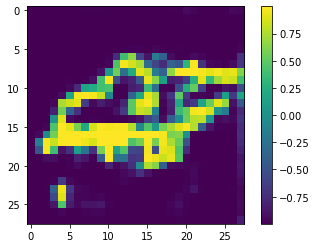

In [24]:
with torch.no_grad():
    plt.imshow(gen(torch.randn(100, device = device)).view(28,28).cpu())
    plt.colorbar()
    plt.show()

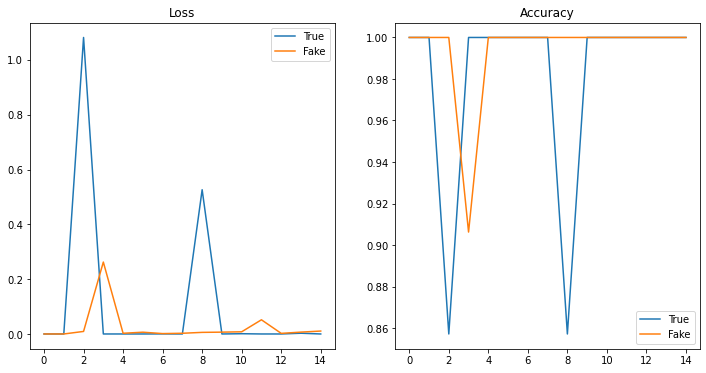

In [25]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(losses_true_epoch, label = "True")
plt.plot(losses_fake_epoch, label = "Fake")
plt.legend()
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(accuracies_true_epoch, label = "True")
plt.plot(accuracies_fake_epoch, label = "Fake")
plt.legend()
plt.show()